In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from matplotlib import gridspec

In [2]:
site_group = '30000-sites'
results_dict = {'DELFI_1x': '../../delfi_data_cancer_detection/number_of_sites_analysis/logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.AUC.txt',
                'DELFI_ULP':'../../delfi_downsampled_cancer_detection/number_of_sites_analysis/logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.AUC.txt',
                'LUCAS_1x':'../../lung_validation_cancer_detection/number_of_sites_analysis/logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.AUC.txt',
                'LUCAS_ULP':'../../lung_validation_downsample_cancer_detection/number_of_sites_analysis/logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.AUC.txt',
                'Validation_1x':'../../lung_validation_cancer_detection/validation_analysis/logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.AUC.txt',
                'Validation_ULP':'../../lung_validation_downsample_cancer_detection/validation_analysis/logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.AUC.txt'}

#get metadata 
metadata_dict = {'DELFI':'../../../griffin_paper/data/delfi_metadata/analysis/matched_metadata_corrected.txt',
                'LUCAS':'/fh/scratch/delete90/ha_g/realigned_bams/cfDNA_lung-cancer_EGA_hg38/metadata/scripts/lung_validation_cfDNA_metadata.tsv',
                'Validation':'/fh/scratch/delete90/ha_g/realigned_bams/cfDNA_lung-cancer_EGA_hg38/metadata/scripts/lung_validation_cfDNA_metadata.tsv'}

tfx_dict = {'DELFI':'../../metadata/delfi/analysis/Delfi_tumor_fraction_data.txt',
                'LUCAS':'../../metadata/lung_validation/lung_tumor_fraction_data.txt',
                'Validation':'../../metadata/lung_validation/lung_tumor_fraction_data.txt'}
                
# uncorrected_results_dict = {'DELFI_1x_uncorr': '../../delfi_data_cancer_detection/other_analysis/logreg_PCA_results/uncorrected_logreg_results/uncorrected.AUC.txt',
#                 'DELFI_ULP_uncorr': '../../delfi_downsampled_cancer_detection/other_analysis/logreg_PCA_results/uncorrected_logreg_results/uncorrected.AUC.txt'}




In [3]:
iterations = 1000
#groups = ['I','II','III','IV','III-IV','overall']
groups = ['0-0.03TFx', '0.03-0.05TFx', '>0.05TFx', '>0.03TFx','overall']
groupby = 'tfx_group'


In [4]:
boxplot_data = pd.DataFrame()
for dataset in results_dict.keys():
    current = pd.read_csv(results_dict[dataset], sep='\t')
    group_columns = current.columns[current.columns.isin(groups)]
    current = current[group_columns]
    current['dataset'] = dataset
    current = current.set_index('dataset').stack().reset_index()
    current = current.rename(columns = {'level_1':'group',0:'AUC'})
    boxplot_data = boxplot_data.append(current)


In [5]:
# uncorrected_boxplot_data = pd.DataFrame()
# for dataset in uncorrected_results_dict.keys():
#     current = pd.read_csv(uncorrected_results_dict[dataset], sep='\t')
#     keep_columns = current.columns[current.columns.isin(groups)]
#     current = current[keep_columns]
#     current['dataset'] = dataset
#     current = current.set_index('dataset').stack().reset_index()
#     current = current.rename(columns = {'level_1':'group',0:'AUC'})
#     uncorrected_boxplot_data = uncorrected_boxplot_data.append(current)


In [6]:
#https://github.com/mwaskom/seaborn/issues/1076
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if len(l.get_xdata())==2 and np.all(l.get_xdata() == [xmin, xmax]): #modified to prevent element wise comparison failure
                        l.set_xdata([xmin_new, xmax_new])


In [7]:
# fig,ax = plt.subplots(figsize = (9.5,6))
# df = boxplot_data[boxplot_data['dataset'].str.startswith('DELFI')].append(uncorrected_boxplot_data)

# sns.boxplot(x = df['dataset'],
#             y = df['AUC'],
#             hue = df['group'],
#            width = 0.7,
#            fliersize = 2,
#             order = ['DELFI_1x_uncorr','DELFI_1x','DELFI_ULP_uncorr','DELFI_ULP'],
#             hue_order = ['0_TFx','>0-0.05_TFx','>=0.05_TFx','overall'],
#             palette = ['tab:blue','tab:orange','tab:green','tab:red','tab:grey'],
#             linewidth = 1,
#            ax = ax)

# ax.legend(bbox_to_anchor = [1,1], loc = 'upper left');
# adjust_box_widths(fig,.8)
# ax.set_ylim(-0.05,1.05)
# ax.set_title('GC correction')
# fig.savefig('plots/GC_correction_delfi_boxplot.pdf')

In [8]:
probabilities = pd.DataFrame()

for dataset in results_dict.keys():
    current_path = results_dict[dataset].rsplit('.AUC.txt',1)[0]+'.probabilities.txt'
    print(current_path)
    current = pd.read_csv(current_path, sep='\t')

    if not 'probability' in current.columns: #for validation set, there are are no bootstrap iterations
        current['probability'] = current[np.arange(iterations).astype(str)].median(axis = 1)
    current = current[['sample','status','probability']]
    current['dataset'] = dataset
    
    metadata_path = metadata_dict[dataset.split('_')[0]]
    metadata = pd.read_csv(metadata_path,sep='\t')
    metadata = metadata.rename(columns = {'new_sample_name':'sample'})
    
    metadata = metadata[['sample','Stage']]
     
    merged = current.merge(metadata, on ='sample')
    
    
    tfx_path = tfx_dict[dataset.split('_')[0]]
    tfx = pd.read_csv(tfx_path,sep='\t')
    
    merged = merged.merge(tfx[['sample','tumor_fraction']], on = 'sample')
    
    if 'Stage' in merged.columns:
        merged['Stage']=merged['Stage'].str.strip('ABC')
    
    #for the validation dataset, combine stage III and IV
    if dataset.startswith('Validation'):
        merged['Stage'] = merged['Stage'].replace('III','III-IV').replace('IV','III-IV')
        
    print(len(current),len(merged))
    
    probabilities = probabilities.append(merged, ignore_index = True)



../../delfi_data_cancer_detection/number_of_sites_analysis/logreg_PCA_results/30000-sites_logreg_results/30000-sites.probabilities.txt
423 423
../../delfi_downsampled_cancer_detection/number_of_sites_analysis/logreg_PCA_results/30000-sites_logreg_results/30000-sites.probabilities.txt
423 423
../../lung_validation_cancer_detection/number_of_sites_analysis/logreg_PCA_results/30000-sites_logreg_results/30000-sites.probabilities.txt
287 287
../../lung_validation_downsample_cancer_detection/number_of_sites_analysis/logreg_PCA_results/30000-sites_logreg_results/30000-sites.probabilities.txt
287 287
../../lung_validation_cancer_detection/validation_analysis/logreg_PCA_results/30000-sites_logreg_results/30000-sites.probabilities.txt
431 431
../../lung_validation_downsample_cancer_detection/validation_analysis/logreg_PCA_results/30000-sites_logreg_results/30000-sites.probabilities.txt
431 431


In [9]:
# #group test data by tumor fraction
# probabilities['tfx_group'] = np.where(probabilities['tumor_fraction']==0,"0_TFx",probabilities['tumor_fraction'])
# probabilities['tfx_group'] = np.where((probabilities['tumor_fraction']>0) & (probabilities['tumor_fraction']<0.05),">0-0.05_TFx",probabilities['tfx_group'])
# probabilities['tfx_group'] = np.where((probabilities['tumor_fraction']>=0.05),">=0.05_TFx",probabilities['tfx_group'])

#add tumor fraction groups
probabilities['tfx_group'] = 'none'
a = 0
for b in [0.03,0.05]:
    tfx_group_name = str(a)+'-'+str(b)+'TFx'
    probabilities['tfx_group'] = np.where((probabilities['status']==1) & (probabilities['tumor_fraction']>=a) & (probabilities['tumor_fraction']<b),tfx_group_name,probabilities['tfx_group'])
    a=b
#if group maxes don't go all the way to 1, add a group > max val
if b<1:
    tfx_group_name = '>'+str(b)+'TFx'
    probabilities['tfx_group'] = np.where((probabilities['status']==1) & (probabilities['status']==1) & (probabilities['tumor_fraction']>=b),tfx_group_name,probabilities['tfx_group'])
#specify tfx group for healthy donors
probabilities['tfx_group'] = np.where((probabilities['status']==0),'Healthy',probabilities['tfx_group'])


#for validation dataset group all samples >0.03
probabilities['tfx_group'] = np.where((probabilities['tumor_fraction']>=0.03) & (probabilities['dataset'].str.startswith('Validation')) & (probabilities['status']==1),'>0.03TFx',probabilities['tfx_group'])



In [22]:
boxplot_palette = {'LUCAS':['tab:blue','tab:orange','tab:green','tab:grey'],
                  'DELFI':['tab:blue','tab:orange','tab:green','tab:grey'],
                  'Validation':['tab:blue','tab:red','tab:grey']}

208 215
0-0.03TFx 354 354
0.03-0.05TFx 252 252
>0.05TFx 247 247
>0.03TFx 215 215
overall 423 423


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


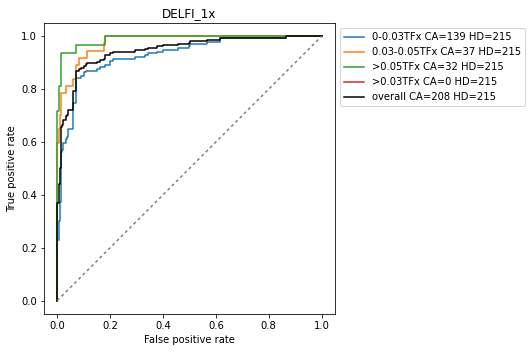

208 215
0-0.03TFx 354 354
0.03-0.05TFx 252 252
>0.05TFx 247 247
>0.03TFx 215 215
overall 423 423


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


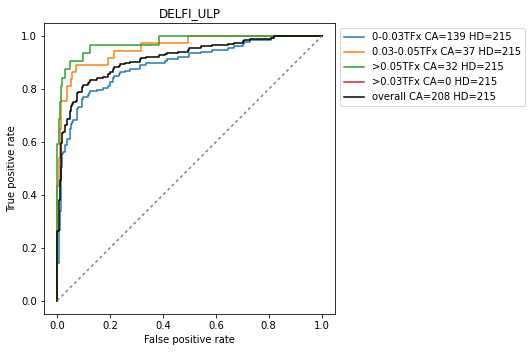

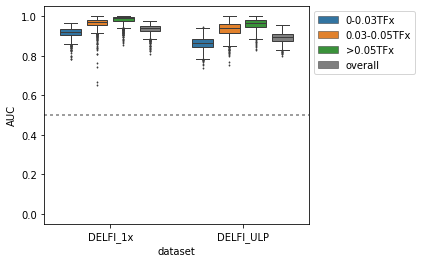

129 158
0-0.03TFx 222 222
0.03-0.05TFx 179 179
>0.05TFx 202 202
>0.03TFx 158 158
overall 287 287


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


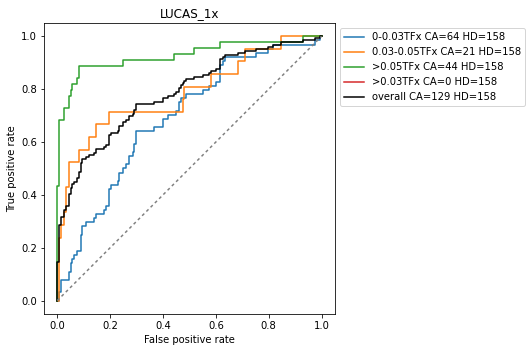

129 158
0-0.03TFx 222 222
0.03-0.05TFx 179 179
>0.05TFx 202 202
>0.03TFx 158 158
overall 287 287


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


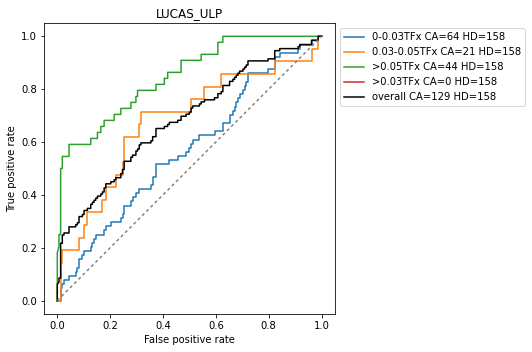

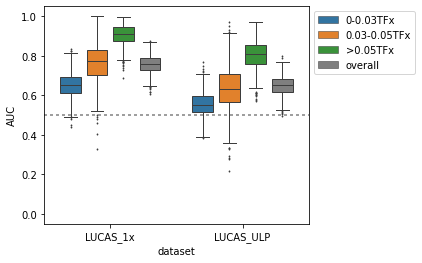

46 385
0-0.03TFx 425 425
0.03-0.05TFx 385 385
>0.05TFx 385 385
>0.03TFx 391 391
overall 431 431


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


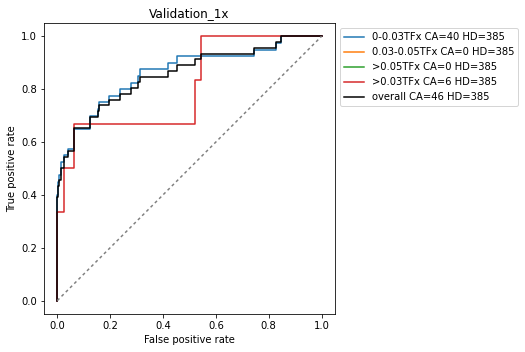

46 385
0-0.03TFx 425 425
0.03-0.05TFx 385 385
>0.05TFx 385 385
>0.03TFx 391 391
overall 431 431


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


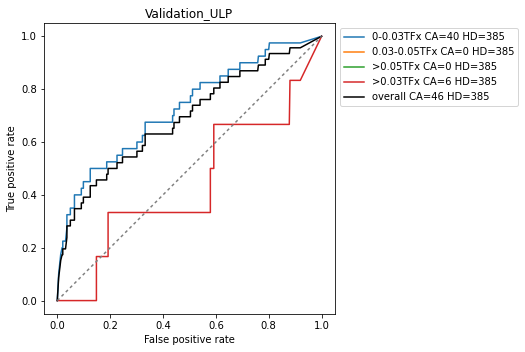

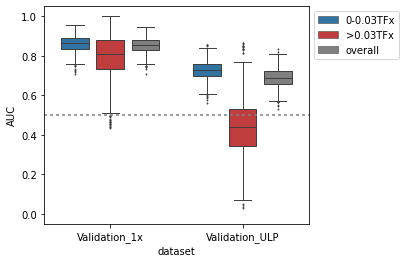

In [24]:
for dataset_name in ['DELFI','LUCAS','Validation']:
    for data_type in ['1x','ULP']:
        fig,ax = plt.subplots(figsize = (9.5,6))  
        dataset = dataset_name+'_'+data_type
        df1 = probabilities[probabilities['dataset']==dataset]

        #get healthy
        HD = df1[df1['status']==0]

        #get cancer with known stage
        CA = df1[(df1[groupby].isin(groups)) & (df1['status']==1)]
        del(df1)

        print(len(CA),len(HD))

        for group in groups:
            if group=='overall':
                current_cancer = CA
                color = 'black'
            else:
                current_cancer = CA[(CA[groupby]==group)]
                color = None
                
            current = current_cancer.append(HD)
            print(group,len(current), len(HD)+len(current_cancer))
            fpr, tpr, _ = roc_curve(current['status'].values,current['probability'].values)
            ax.plot(fpr,tpr, label = group+' CA='+str(len(current_cancer))+' HD='+str(len(HD)), color = color)
        
        
        ax.set_title(dataset)
        ax.set_ylim(-0.05,1.05)
        ax.set_aspect('equal')

        ax.plot([0,1],[0,1], color = 'grey', dashes = (2,2))
        ax.set_xlabel('False positive rate')
        ax.set_ylabel('True positive rate')

        ax.legend(bbox_to_anchor = [1,1], loc = 'upper left')
        fig.subplots_adjust(right=.55)    
        plt.savefig('plots/AUC_by_'+groupby+'.'+dataset_name+'.'+data_type+'.pdf')
        plt.show()
        
        
    #make boxplot for supplement
    fig,ax = plt.subplots(figsize = (7,4))  
    current_boxplot_data = boxplot_data[boxplot_data['dataset'].str.startswith(dataset_name)]
    
    
    current_groups = [m for m in groups if m in current_boxplot_data['group'].values]
    sns.boxplot(x = current_boxplot_data['dataset'],
                y = current_boxplot_data['AUC'],
                hue = current_boxplot_data['group'],
               width = 0.8,
                palette = boxplot_palette[dataset_name],
               order = [dataset_name+'_1x',dataset_name+'_ULP'],
                hue_order = current_groups,
               ax = ax, fliersize = 1, linewidth = 1)
    
    adjust_box_widths(fig,.8)
    ax.legend(bbox_to_anchor = [1,1], loc = 'upper left');
    ax.set_ylim(-0.05,1.05)
    ax.axhline(.5, color = 'grey', dashes = [2,2])
    fig.subplots_adjust(right = 0.65)
    plt.savefig('plots/AUC_by_'+groupby+'.'+dataset_name+'.boxplot.pdf')
    plt.show()


In [16]:
# metrics_df = pd.DataFrame(index = boxplot_data['group'].unique())
# for dataset in results_dict.keys():
#     df = boxplot_data[boxplot_data['dataset']==dataset]
#     metrics_df[dataset] = df.groupby('group')['AUC'].median().copy()

    
# display(metrics_df)

# #format for table
# metrics_df = np.round(metrics_df,3)
# metrics_df.columns = metrics_df.columns + ' sites'
# metrics_df.index = metrics_df.index.str.replace('_',' ')    


In [17]:
to_print = pd.DataFrame(index = groups) #+ ['overall']
for dataset in results_dict.keys():
    CI_data = pd.read_csv(results_dict[dataset].rsplit('.AUC',1)[0]+'.CI.txt', sep='\t')
    CI_data = CI_data.rename(columns = {'Unnamed: 0':'group'})
    CI_data = CI_data.set_index('group')
    keep_index = CI_data.index[CI_data.index.isin(groups)]
    CI_data = CI_data.loc[keep_index]
    CI_data = CI_data.round(2)
    CI_data[dataset] = CI_data['median'].astype(str) + ' (' + CI_data['0.025'].astype(str) + '-' + CI_data['0.975'].astype(str) + ')'
    to_print[dataset]  = CI_data[dataset]
to_print

,DELFI_1x,DELFI_ULP,LUCAS_1x,LUCAS_ULP,Validation_1x,Validation_ULP
0-0.03TFx,0.92 (0.85-0.96),0.87 (0.8-0.92),0.65 (0.52-0.77),0.55 (0.43-0.67),0.87 (0.78-0.93),0.73 (0.64-0.82)
0.03-0.05TFx,0.97 (0.89-1.0),0.94 (0.85-0.99),0.78 (0.58-0.95),0.63 (0.41-0.84),NaN,NaN
>0.05TFx,0.99 (0.92-1.0),0.97 (0.9-1.0),0.91 (0.8-0.99),0.81 (0.66-0.93),NaN,NaN
>0.03TFx,NaN,NaN,NaN,NaN,0.81 (0.54-0.99),0.44 (0.17-0.72)
overall,0.94 (0.88-0.97),0.89 (0.84-0.94),0.76 (0.67-0.83),0.65 (0.56-0.74),0.86 (0.78-0.91),0.69 (0.6-0.78)


In [18]:
to_print[['DELFI_1x','DELFI_ULP']]

,DELFI_1x,DELFI_ULP
0-0.03TFx,0.92 (0.85-0.96),0.87 (0.8-0.92)
0.03-0.05TFx,0.97 (0.89-1.0),0.94 (0.85-0.99)
>0.05TFx,0.99 (0.92-1.0),0.97 (0.9-1.0)
>0.03TFx,NaN,NaN
overall,0.94 (0.88-0.97),0.89 (0.84-0.94)


In [19]:
to_print[['LUCAS_1x','LUCAS_ULP']]

,LUCAS_1x,LUCAS_ULP
0-0.03TFx,0.65 (0.52-0.77),0.55 (0.43-0.67)
0.03-0.05TFx,0.78 (0.58-0.95),0.63 (0.41-0.84)
>0.05TFx,0.91 (0.8-0.99),0.81 (0.66-0.93)
>0.03TFx,NaN,NaN
overall,0.76 (0.67-0.83),0.65 (0.56-0.74)


In [20]:
to_print[['Validation_1x','Validation_ULP']]

,Validation_1x,Validation_ULP
0-0.03TFx,0.87 (0.78-0.93),0.73 (0.64-0.82)
0.03-0.05TFx,NaN,NaN
>0.05TFx,NaN,NaN
>0.03TFx,0.81 (0.54-0.99),0.44 (0.17-0.72)
overall,0.86 (0.78-0.91),0.69 (0.6-0.78)


In [21]:
# to_print2 = pd.DataFrame(index = groups) #+ ['overall']
# for dataset in uncorrected_results_dict.keys():
#     CI_data = pd.read_csv(uncorrected_results_dict[dataset].rsplit('.AUC',1)[0]+'.CI.txt', sep='\t')
#     CI_data = CI_data.rename(columns = {'Unnamed: 0':'group'})
#     CI_data = CI_data.set_index('group')
#     keep_index = CI_data.index[CI_data.index.isin(groups)]
#     CI_data = CI_data.loc[keep_index]
#     CI_data = CI_data.round(2)
#     CI_data[dataset] = CI_data['median'].astype(str) + ' (' + CI_data['0.025'].astype(str) + '-' + CI_data['0.975'].astype(str) + ')'
#     to_print2[dataset]  = CI_data[dataset]
# to_print2